# Imports
 Note that this notebook has a lot of redundant code. Use Test_Explainer_Discoverer instead.

In [1]:
import sys 
import os
sys.path.append("../")
from classifier.DenseNet import pretrained_classifier as celeba_classifier
from classifier.SimpleNet import pretrained_classifier as shapes_classifier
from data_loader.data_loader import CelebALoader, ShapesLoader

from explainer.networks_128 import Discriminator_Ordinal as celeba_Discriminator_Ordinal
from explainer.networks_128 import Generator_Encoder_Decoder as celeba_Generator_Encoder_Decoder
from explainer.networks_128 import Discriminator_Contrastive as celeba_Discriminator_Contrastive

from explainer.networks_64 import Discriminator_Ordinal as shapes_Discriminator_Ordinal
from explainer.networks_64 import Generator_Encoder_Decoder as shapes_Generator_Encoder_Decoder
from explainer.networks_64 import Discriminator_Contrastive as shapes_Discriminator_Contrastive

from test_explainer import test

import tensorflow.contrib.slim as slim
import tensorflow as tf
import numpy as np
from utils import save_images, read_data_file, inverse_image, make3d
from losses import *
import pdb
import yaml
import time
import pandas as pd
import scipy.io as sio
from datetime import datetime
import random
import warnings
import argparse
warnings.filterwarnings("ignore") 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.chdir('..')

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

# Initialize

In [3]:
# binary_attribute = 'Smile'
binary_attribute = 'Young'

config = './configs/celebA_{}_Explainer.yaml'.format(binary_attribute)
config = yaml.load(open(config))
print(config)

config = './configs/celebA_{}_Explainer_disentangled_2.yaml'.format(binary_attribute)
config = yaml.load(open(config))
print(config)

{'ckpt_dir_continue': './output/explainer/CelebA-Young-Binary', 'save_summary': 20, 'image_label_dict': './output/classifier/CelebA-Young/explainer_input/list_attr_10.txt', 'target_class': 1, 'image_dir': './data/CelebA/images/', 'lambda_r': 0.0, 'lambda_cls': 1, 'num_bins': 10, 'count_to_save': 20, 'num_channel': 3, 'cls_experiment': './output/classifier/CelebA-Young', 'batch_size': 32, 'dataset': 'CelebA', 'num_class': 2, 'discriminate_every_nth': 1, 'log_dir': './output/explainer', 'k_dim': 1, 'lambda_GAN': 1, 'epochs': 300, 'input_size': 128, 'name': 'CelebA-Young-Binary', 'generate_every_nth': 5, 'lambda_cyc': 100}
{'ckpt_dir_continue': './output/explainer/CelebA-Young-Binary-Disentangled_2', 'save_summary': 20, 'image_label_dict': './output/classifier/CelebA-Young/explainer_input/list_attr_10.txt', 'target_class': 1, 'image_dir': './data/CelebA/images/', 'lambda_r': 1.0, 'lambda_cls': 1, 'num_bins': 10, 'count_to_save': 20, 'num_channel': 3, 'cls_experiment': './output/classifier

In [5]:
# config_path = './configs/shapes_redcolor_Explainer_disentangled_2_main_dim_r50.yaml'
# config_path = './configs/shapes_redcolor_Explainer_disentangled_2_newarch_gr.yaml'
config_path = './configs/shapes_redcolor_Explainer_disentangled_2_newarch_r10.yaml'
config_path = './configs/redshapes_experiments/shapes_redcolor_Explainer.yaml'
config = yaml.load(open(config_path))
print(config)

{'ckpt_dir_continue': './output/discoverer/redshapes_experiments/shapes_redcolor_Explainer', 'max_samples_per_bin': 85000, 'image_dir': '', 'image_label_dict': './output/classifier/shapes-redcolor/explainer_input/list_attr_3_85000.txt', 'target_class': 1, 'save_summary': 20, 'lambda_r': 0.0, 'lambda_cls': 1, 'num_bins': 3, 'count_to_save': 20, 'num_channel': 3, 'cls_experiment': './output/classifier/shapes-redcolor', 'batch_size': 32, 'dataset': 'shapes', 'num_class': 2, 'discriminate_every_nth': 1, 'log_dir': './output/discoverer/redshapes_experiments', 'k_dim': 1, 'lambda_GAN': 1, 'epochs': 1000, 'input_size': 64, 'name': 'shapes_redcolor_Explainer', 'generate_every_nth': 5, 'lambda_cyc': 100}


In [6]:
HAS_MAIN_DIM = 'main_dim' in config_path or 'plus' in config_path
print ('Support main dimension? {}'.format(HAS_MAIN_DIM))

Support main dimension? False


In [7]:
assets_dir = os.path.join(config['log_dir'], config['name'])
log_dir = os.path.join(assets_dir, 'log')
ckpt_dir = os.path.join(assets_dir, 'ckpt_dir')
sample_dir = os.path.join(assets_dir, 'sample')
test_dir = os.path.join(assets_dir, 'test')

    
# ============= Experiment Parameters =============
ckpt_dir_cls = config['cls_experiment']
BATCH_SIZE = config['batch_size']
EPOCHS = config['epochs']
channels = config['num_channel']
input_size = config['input_size']
NUMS_CLASS_cls = config['num_class']
NUMS_CLASS = config['num_bins']
target_class = config['target_class']
lambda_GAN = config['lambda_GAN']
lambda_cyc = config['lambda_cyc']
lambda_cls = config['lambda_cls']
save_summary = int(config['save_summary'])
ckpt_dir_continue = config['ckpt_dir_continue']
# there is a main knob, at index k_dim, and k_dim disentangled knobs at indices 0..k_dim-1
k_dim = config['k_dim']
k_dim_plus = k_dim + 1
lambda_r = config['lambda_r']
disentangle = k_dim > 1
discriminate_evert_nth = config['discriminate_every_nth']
generate_every_nth = config['generate_every_nth']
dataset = config['dataset']
if dataset == 'CelebA':
    pretrained_classifier = celeba_classifier
    my_data_loader = CelebALoader()
    Discriminator_Ordinal = celeba_Discriminator_Ordinal
    Generator_Encoder_Decoder = celeba_Generator_Encoder_Decoder
    Discriminator_Contrastive = celeba_Discriminator_Contrastive
elif dataset == 'shapes':
    pretrained_classifier = shapes_classifier
    if 'max_samples_per_bin' in config.keys():
        my_data_loader = ShapesLoader(dbg_mode=True, dbg_batch_size=config['batch_size'],
                                      dbg_n_bins=config['num_bins'], 
                                      dbg_max_samples_per_bin=config['max_samples_per_bin'])
    else:
        my_data_loader = ShapesLoader(dbg_mode=True, dbg_batch_size=config['batch_size'],
                                      dbg_n_bins=config['num_bins'])
    Discriminator_Ordinal = shapes_Discriminator_Ordinal
    Generator_Encoder_Decoder = shapes_Generator_Encoder_Decoder
    Discriminator_Contrastive = shapes_Discriminator_Contrastive
if ckpt_dir_continue == '':
    continue_train = False
else:
    ckpt_dir_continue = os.path.join(ckpt_dir_continue, 'ckpt_dir')
    continue_train = True

Debug mode activated. Only a few samples from the shapes datasets will be considered.


# Model

In [8]:
def convert_ordinal_to_binary(y,n):
    y = np.asarray(y).astype(int)
    new_y = np.zeros([y.shape[0], n])
    new_y[:,0] = y
    for i in range(0,y.shape[0]):
        for j in range(1,y[i]+1):
            new_y[i,j] = 1
    return new_y

In [9]:
if HAS_MAIN_DIM:
    # ============= placeholder =============
    x_source = tf.placeholder(tf.float32, [None, input_size, input_size, channels], name='x_source')
    y_s = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_s')
    y_source = y_s[:, 0]
    train_phase = tf.placeholder(tf.bool, name='train_phase')

    y_t = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_t')
    y_target = y_t[:, 0]

    if disentangle:
        y_regularizer = tf.placeholder(tf.int32, [None], name='y_regularizer')
        y_r = tf.placeholder(tf.float32, [None, k_dim], name='y_r')
        y_r_0 = tf.zeros_like(y_r, name='y_r_0')

    # ============= G & D =============
    G = Generator_Encoder_Decoder("generator")  # with conditional BN, SAGAN: SN here as well
    D = Discriminator_Ordinal("discriminator")  # with SN and projection

    # TODO AG, currently D only conditions on delta, but not the "knob" index.
    real_source_logits = D(x_source, y_s, NUMS_CLASS, "NO_OPS")
    # TODO AG, currently G conditions on a one-hot vector of size NUMS_CLASS * k_dim. Make it more efficient?
    if disentangle:
        fake_target_img, fake_target_img_embedding = G(x_source, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_target, NUMS_CLASS * k_dim_plus)
        fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim_plus)
        fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase, y_regularizer * NUMS_CLASS + y_source,
                                                           NUMS_CLASS * k_dim_plus)
        fake_source_main_dim_img, fake_source_main_dim_img_embedding = G(fake_target_img, train_phase,
                                                                         k_dim * NUMS_CLASS + y_source,
                                                                         NUMS_CLASS * k_dim_plus)
    else:
        fake_target_img, fake_target_img_embedding = G(x_source, train_phase, y_target, NUMS_CLASS)
        fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase, y_source, NUMS_CLASS)
        fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase, y_source, NUMS_CLASS)
    fake_target_logits = D(fake_target_img, y_t, NUMS_CLASS, None)

    # ============= pre-trained classifier =============      
    real_img_cls_logit_pretrained, real_img_cls_prediction = pretrained_classifier(x_source, NUMS_CLASS_cls,
                                                                                   reuse=False, name='classifier')
    fake_img_cls_logit_pretrained, fake_img_cls_prediction = pretrained_classifier(fake_target_img, NUMS_CLASS_cls,
                                                                                   reuse=True)
    real_img_recons_cls_logit_pretrained, real_img_recons_cls_prediction = pretrained_classifier(fake_source_img,
                                                                                                 NUMS_CLASS_cls,
                                                                                                 reuse=True)
    # ============= regularizer constrastive discriminator loss =============
    if disentangle:
        R = Discriminator_Contrastive("disentangler")

        regularizer_fake_target_v_source_logits = R(tf.concat([x_source, fake_target_img], axis=-1), k_dim)
        regularizer_fake_source_v_target_logits = R(tf.concat([fake_target_img, fake_source_img], axis=-1), k_dim)
        regularizer_fake_source_v_source_logits = R(tf.concat([x_source, fake_source_img], axis=-1), k_dim)
        # TODO: due to memory problems, regularizer_fake_source_recon_v_source_logits is removed from disentangler loss
        #  because this seems to be the easiest task to do
        # regularizer_fake_source_recon_v_source_logits = R(tf.concat([x_source, fake_source_recons_img], axis=-1), k_dim)

else:
    # ============= placeholder =============
    x_source = tf.placeholder(tf.float32, [None, input_size, input_size, channels], name='x_source')
    y_s = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_s')
    y_source = y_s[:, 0]
    train_phase = tf.placeholder(tf.bool, name='train_phase')

    y_t = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_t')
    y_target = y_t[:, 0]

    if disentangle:
        y_regularizer = tf.placeholder(tf.int32, [None], name='y_regularizer')
        y_r = tf.placeholder(tf.float32, [None, k_dim], name='y_r')
        y_r_0 = tf.zeros_like(y_r, name='y_r_0')

    # ============= G & D =============
    G = Generator_Encoder_Decoder("generator")  # with conditional BN, SAGAN: SN here as well
    D = Discriminator_Ordinal("discriminator")  # with SN and projection

    # TODO AG, currently D only conditions on delta, but not the "knob" index.
    real_source_logits = D(x_source, y_s, NUMS_CLASS, "NO_OPS")
    # TODO AG, currently G conditions on a one-hot vector of size NUMS_CLASS * k_dim. Make it more efficient?
    if disentangle:
        fake_target_img, fake_target_img_embedding = G(x_source, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_target, NUMS_CLASS * k_dim)
        fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
        fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase,
                                                           y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
    else:
        fake_target_img, fake_target_img_embedding = G(x_source, train_phase, y_target, NUMS_CLASS)
        fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase, y_source, NUMS_CLASS)
        fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase, y_source, NUMS_CLASS)
    fake_target_logits = D(fake_target_img, y_t, NUMS_CLASS, None)

    # ============= pre-trained classifier =============      
    real_img_cls_logit_pretrained, real_img_cls_prediction = pretrained_classifier(x_source, NUMS_CLASS_cls,
                                                                                   reuse=False, name='classifier')
    fake_img_cls_logit_pretrained, fake_img_cls_prediction = pretrained_classifier(fake_target_img, NUMS_CLASS_cls,
                                                                                   reuse=True)
    real_img_recons_cls_logit_pretrained, real_img_recons_cls_prediction = pretrained_classifier(fake_source_img,
                                                                                                 NUMS_CLASS_cls,
                                                                                                 reuse=True)

    # ============= regularizer constrastive discriminator loss =============
    if disentangle:
        R = Discriminator_Contrastive("disentangler")

        regularizer_fake_target_v_source_logits = R(tf.concat([x_source, fake_target_img], axis=-1), k_dim)
        regularizer_fake_source_v_target_logits = R(tf.concat([fake_target_img, fake_source_img], axis=-1), k_dim)
        regularizer_fake_source_v_source_logits = R(tf.concat([x_source, fake_source_img], axis=-1), k_dim)
        regularizer_fake_source_recon_v_source_logits = R(tf.concat([x_source, fake_source_recons_img], axis=-1), k_dim)
    

Tensor("x_source:0", shape=(?, 64, 64, 3), dtype=float32)
Tensor("discriminator/add:0", shape=(?, 32, 32, 64), dtype=float32)
Tensor("discriminator/add_1:0", shape=(?, 16, 16, 128), dtype=float32)
Tensor("discriminator/add_2:0", shape=(?, 8, 8, 256), dtype=float32)
Tensor("discriminator/add_3:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator/Relu:0", shape=(?, 4, 4, 512), dtype=float32)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Encoder-Decoder
Tensor("x_source:0", shape=(?, 64, 64, 3), dtype=float32)
: Tensor("generator/BiasAdd:0", shape=(?, 64, 64, 64), dtype=float32)
: Tensor("generator/add:0", shape=(?, 32, 32, 512), dtype=float32)
: Tensor("generator/add_1:0", shape=(?, 16, 16, 1024), dtype=float32)
: Tensor("generator/add_2:0", shape=(?, 8, 8, 1024), dtype=float32)
: Tensor("generator/add_3:0", shape=(?, 16, 16, 1024), dtype=float32)
: Tensor("generator/add_4:0", shape=(?, 32, 32, 512), dtype=float32)
: Tensor("generator/add_5:0", shape=

# Session

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [11]:
ckpt = tf.train.get_checkpoint_state(ckpt_dir_continue)
if ckpt and ckpt.model_checkpoint_path:
    ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
    print (os.path.join(ckpt_dir_continue, ckpt_name))
    saver.restore(sess, os.path.join(ckpt_dir_continue, ckpt_name))
    print("Successful checkpoint upload")
else:
    print("Failed checkpoint load")

./output/discoverer/redshapes_experiments/shapes_redcolor_Explainer/ckpt_dir/model62500.ckpt
INFO:tensorflow:Restoring parameters from ./output/discoverer/redshapes_experiments/shapes_redcolor_Explainer/ckpt_dir/model62500.ckpt
Successful checkpoint upload


In [12]:
# ============= load pre-trained classifier checkpoint =============
class_vars = [var for var in slim.get_variables_to_restore() if 'classifier' in var.name]
name_to_var_map_local = {var.op.name: var for var in class_vars}
temp_saver = tf.train.Saver(var_list=name_to_var_map_local)
ckpt = tf.train.get_checkpoint_state(ckpt_dir_cls)
ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
temp_saver.restore(sess, os.path.join(ckpt_dir_cls, ckpt_name))
print("Classifier checkpoint loaded.................")
print(ckpt_dir_cls, ckpt_name)

INFO:tensorflow:Restoring parameters from ./output/classifier/shapes-redcolor/cp1_epoch4.ckpt
Classifier checkpoint loaded.................
./output/classifier/shapes-redcolor cp1_epoch4.ckpt


# Plot graphs

In [13]:
all_files = sorted(os.listdir(log_dir))
all_files

['events.out.tfevents.1590467540.9647c2540e83', 'setting.txt']

In [14]:
log_file_name = os.path.join(log_dir, all_files[-2])

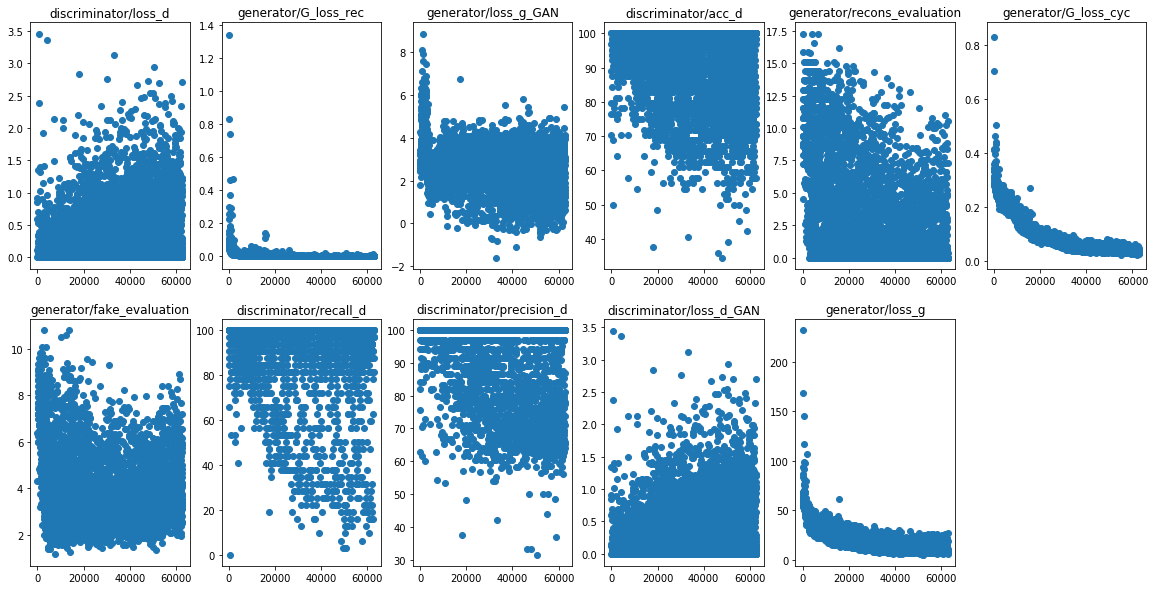

In [15]:
from tensorboard.backend.event_processing import event_accumulator

ea = event_accumulator.EventAccumulator(log_file_name,size_guidance={ 
    event_accumulator.COMPRESSED_HISTOGRAMS: 1,
    event_accumulator.IMAGES: 1,
    event_accumulator.AUDIO: 1,
    event_accumulator.SCALARS: 5000,
    event_accumulator.HISTOGRAMS: 1,
    })
ea.Reload()
scalars = ea.Tags()['scalars']
def plot(scalars):
    plt.figure(figsize=(20,10))
    n = int(len(scalars)/2)
    if len(scalars)%2 != 0:
        n += 1
    counter = 1
    for s in scalars:
        plt.subplot(2,n,counter)
        df = pd.DataFrame(ea.Scalars(s))
        plt.scatter(x=df['step'], y=df['value'])
        plt.title(s)
        counter += 1
    plt.show()    
plot(scalars)

# Run an Experiment

In [16]:
ckpt_dir_cls

'./output/classifier/shapes-redcolor'

In [17]:
# ============= Data =============
try:
    categories, file_names_dict = my_data_loader.read_data_file(config['image_label_dict'])
except:
    print("Problem in reading input data file : ", config['image_label_dict'])
    sys.exit()
data = np.asarray(list(file_names_dict.keys()))
print("The classification categories are: ")
print(categories)
print('The size of the training set: ', data.shape[0])
data[0:10]

The classification categories are: 
['[0.00', '0.33)', '[0.33', '0.67)', '[0.67', '1.00)']
The size of the training set:  170000


array(['315194', '381232', '371313', '3819', '365213', '304436', '469904',
       '354789', '85232', '39523'], dtype='<U6')

In [18]:
print ('k_dim: {}, k_dim_plus: {}'.format(k_dim, k_dim_plus))

k_dim: 1, k_dim_plus: 2


In [19]:
if HAS_MAIN_DIM:
    generation_dim = k_dim_plus
else:
    generation_dim = k_dim
    
fake_img = np.empty([])
real_prediction = np.empty([])
fake_prediction = np.empty([])
real_img = np.empty([])

# np.random.shuffle(data)
image_paths = data

num_seed_imgs = 8
img, labels = my_data_loader.load_images_and_labels(image_paths[0:num_seed_imgs], config['image_dir'], 1,
                                     file_names_dict, input_size, channels, do_center_crop=True)

print("Size of source images: ", img.shape)

labels = np.repeat(labels, NUMS_CLASS * generation_dim, 0)
labels = labels.ravel()
labels = convert_ordinal_to_binary(labels, NUMS_CLASS)
img_repeat = np.repeat(img, NUMS_CLASS * generation_dim, 0)

print("Size of repeated images: ", img_repeat.shape)

target_labels = np.asarray([np.asarray(range(NUMS_CLASS)) for j in range(num_seed_imgs * generation_dim)])
target_labels = target_labels.ravel()

identity_ind = labels == target_labels
target_labels = convert_ordinal_to_binary(target_labels, NUMS_CLASS)

if disentangle:
    target_disentangle_ind = np.asarray(
        [np.repeat(np.asarray(range(generation_dim)), NUMS_CLASS) for j in range(num_seed_imgs)])
    target_disentangle_ind = target_disentangle_ind.ravel()
    target_disentangle_ind_one_hot = np.eye(generation_dim)[target_disentangle_ind][:, 0:k_dim]
    target_disentangle_ind_one_hot[identity_ind, :] = 0
    my_feed_dict = {y_t: target_labels, x_source: img_repeat, train_phase: False,
                    y_s: labels,
                    y_regularizer: target_disentangle_ind, y_r: target_disentangle_ind_one_hot}
else:
    my_feed_dict = {y_t: target_labels, x_source: img_repeat, train_phase: False,
                    y_s: labels}



FAKE_IMG, real_pred, fake_pred = sess.run([ fake_target_img,\
                              real_img_cls_prediction, fake_img_cls_prediction], \
                              feed_dict=my_feed_dict)

real_img = img
fake_img = FAKE_IMG
real_prediction = real_pred
fake_prediction = fake_pred

print(real_img.shape)
print(fake_img.shape)
print(real_prediction.shape)
print(fake_prediction.shape)

8it [00:00, 16131.94it/s]

Size of source images:  (8, 64, 64, 3)
Size of repeated images:  (24, 64, 64, 3)


(8, 64, 64, 3)
(24, 64, 64, 3)
(24, 2)
(24, 2)


# View

In [20]:
def save_target_images(img, num_class, image_size=128,num_channel=3):
    img = make3d(img, num_channel=num_channel, image_size=image_size, row=1, col=num_class)                      
    img = inverse_image(img)
    return img

In [27]:
def view(img, num_samples, NUMS_CLASS, generation_dim, real_pred, FAKE_IMG, fake_pred, image_size):
    img = inverse_image(img)
    start = 0
    fake_pred = np.round(fake_pred, decimals=2)
    for i in range(num_samples):
        plt.figure(figsize = (3,3))
        plt.imshow(img[i])
        plt.title(str(" Output of pre. cls: ") + str(real_pred[start][1]))
        plt.show()
        for j in range(generation_dim):
            plt.figure(figsize = (3 * NUMS_CLASS, 3))
            temp = save_target_images(FAKE_IMG[start+j*NUMS_CLASS:start+(j+1)*NUMS_CLASS], NUMS_CLASS, 
                                      image_size=image_size)
            if HAS_MAIN_DIM and j == generation_dim-1:
                plt.title("Main Knob - ".format(j)+"Generated image cls output: " + str(
                    fake_pred[start+j*NUMS_CLASS:start+(j+1)*NUMS_CLASS][:, 1]))
            else:
                plt.title("Knob {} - ".format(j+1)+"Generated image cls output: " + str(
                    fake_pred[start+j*NUMS_CLASS:start+(j+1)*NUMS_CLASS][:, 1]))
            plt.imshow(temp)
            plt.show()

        start = start + NUMS_CLASS * generation_dim

# Save Results

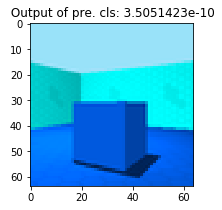

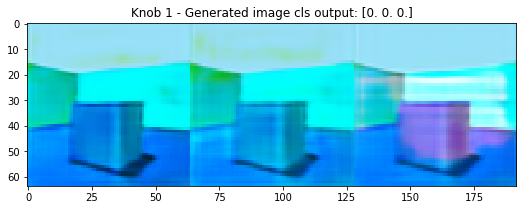

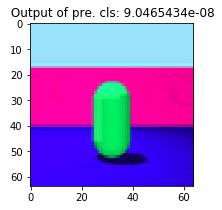

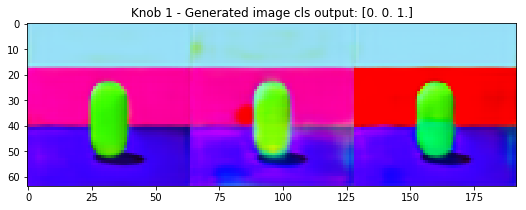

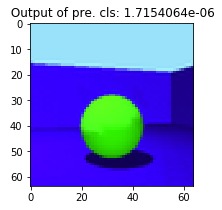

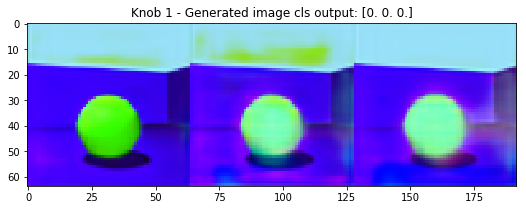

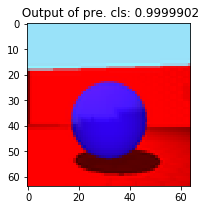

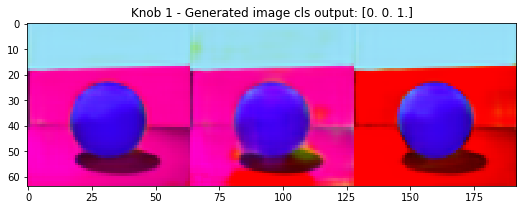

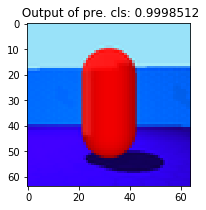

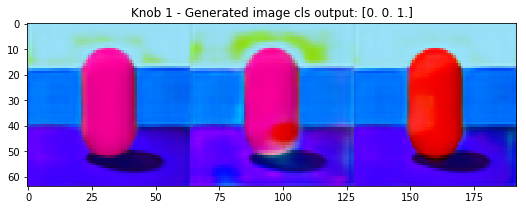

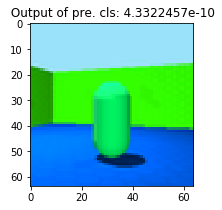

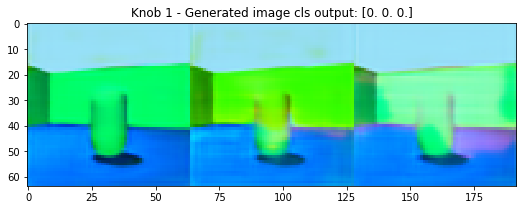

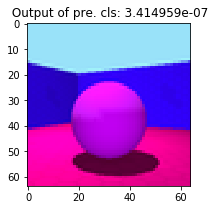

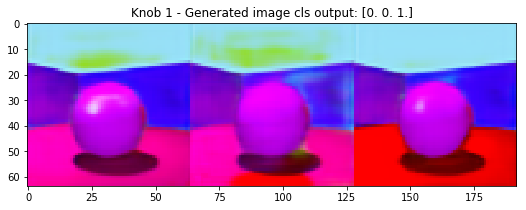

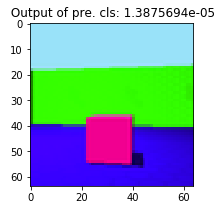

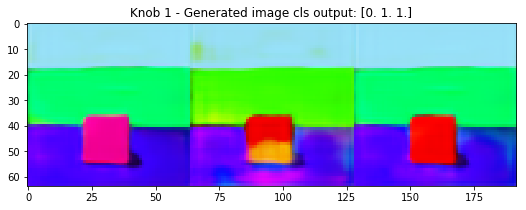

In [28]:
num_samples = 8
view(real_img[0:num_samples], num_samples, NUMS_CLASS, generation_dim, real_prediction[0:num_samples*NUMS_CLASS*generation_dim], 
     fake_img[0:num_samples*NUMS_CLASS*generation_dim], fake_prediction[0:num_samples*NUMS_CLASS*generation_dim], image_size=64)


# Legacy dealing with memory issues

In [ ]:
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.allocator_type = 'BFC'
#sess_config.gpu_options.per_process_gpu_memory_fraction = 0.40
sess_config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess_config.gpu_options.allow_growth = True
sess_config

# Before adding main dim

In [ ]:
# ============= placeholder =============
x_source = tf.placeholder(tf.float32, [None, input_size, input_size, channels], name='x_source')
y_s = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_s')
y_source = y_s[:, 0]
train_phase = tf.placeholder(tf.bool, name='train_phase')

y_t = tf.placeholder(tf.int32, [None, NUMS_CLASS], name='y_t')
y_target = y_t[:, 0]

if disentangle:
    y_regularizer = tf.placeholder(tf.int32, [None], name='y_regularizer')
    y_r = tf.placeholder(tf.float32, [None, k_dim], name='y_r')
    y_r_0 = tf.zeros_like(y_r, name='y_r_0')

# ============= G & D =============
G = Generator_Encoder_Decoder("generator")  # with conditional BN, SAGAN: SN here as well
D = Discriminator_Ordinal("discriminator")  # with SN and projection

# TODO AG, currently D only conditions on delta, but not the "knob" index.
real_source_logits = D(x_source, y_s, NUMS_CLASS, "NO_OPS")
# TODO AG, currently G conditions on a one-hot vector of size NUMS_CLASS * k_dim. Make it more efficient?
if disentangle:
    fake_target_img, fake_target_img_embedding = G(x_source, train_phase,
                                                   y_regularizer * NUMS_CLASS + y_target, NUMS_CLASS * k_dim)
    fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase,
                                                   y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
    fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase,
                                                       y_regularizer * NUMS_CLASS + y_source, NUMS_CLASS * k_dim)
else:
    fake_target_img, fake_target_img_embedding = G(x_source, train_phase, y_target, NUMS_CLASS)
    fake_source_img, fake_source_img_embedding = G(fake_target_img, train_phase, y_source, NUMS_CLASS)
    fake_source_recons_img, x_source_img_embedding = G(x_source, train_phase, y_source, NUMS_CLASS)
fake_target_logits = D(fake_target_img, y_t, NUMS_CLASS, None)

# ============= pre-trained classifier =============      
real_img_cls_logit_pretrained, real_img_cls_prediction = pretrained_classifier(x_source, NUMS_CLASS_cls,
                                                                               reuse=False, name='classifier')
fake_img_cls_logit_pretrained, fake_img_cls_prediction = pretrained_classifier(fake_target_img, NUMS_CLASS_cls,
                                                                               reuse=True)
real_img_recons_cls_logit_pretrained, real_img_recons_cls_prediction = pretrained_classifier(fake_source_img,
                                                                                             NUMS_CLASS_cls,
                                                                                             reuse=True)

# ============= regularizer constrastive discriminator loss =============
if disentangle:
    R = Discriminator_Contrastive("disentangler")

    regularizer_fake_target_v_source_logits = R(tf.concat([x_source, fake_target_img], axis=-1), k_dim)
    regularizer_fake_source_v_target_logits = R(tf.concat([fake_target_img, fake_source_img], axis=-1), k_dim)
    regularizer_fake_source_v_source_logits = R(tf.concat([x_source, fake_source_img], axis=-1), k_dim)
    regularizer_fake_source_recon_v_source_logits = R(tf.concat([x_source, fake_source_recons_img], axis=-1), k_dim)